# Code for plots in the directional filter paper

#### Importing

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from filterbank.components import Filterbank, TransmissionLine, ManifoldFilter, DirectionalFilter

plt.style.use('~/Repos/louis-style-docs/default.mplstyle')

fig_path = "~/Repos/filterbank-performance/paper_dir_filter_figures/"


#### Settings

In [4]:
nF = int(2e4)
f = np.linspace(210e9,450e9,nF)

f0_min = 220e9
f0_max = 440e9

## Variances
sigma_Ql = 0.2
sigma_f0 = 0.085


Z0_res = 80
eps_eff_res = 40
Qi_res = np.inf


Z0_thru = 80
eps_eff_thru = 40

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}



#### Generate numerical models

In [5]:
#-----------------------------
single_filter_MF = ManifoldFilter(
    f0=330e9,
    Ql=500,
    TransmissionLines=TransmissionLinesDict,
    compensate=False
)
single_filter_MF.S(f)
single_filter_MF.realized_parameters()

single_filter_DF = ManifoldFilter(
    f0=330e9,
    Ql=500,
    TransmissionLines=TransmissionLinesDict,
    compensate=False
)
single_filter_DF.S(f)
single_filter_DF.realized_parameters()
#-----------------------------



#-----------------------------
## Manifold filter, no variance
FB_MF_no_variance = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=0,
    sigma_Ql=0,
    compensate=False
)
FB_MF_no_variance.S(f)
FB_MF_no_variance.realized_parameters()

## Manifold filter, variance
FB_MF_variance = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=sigma_f0,
    sigma_Ql=sigma_Ql,
    compensate=False
)
FB_MF_variance.S(f)
FB_MF_variance.realized_parameters()
#-----------------------------



#-----------------------------
## Directional filter, no variance
FB_DF_no_variance = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=0,
    sigma_Ql=0,
    compensate=False
)
FB_DF_no_variance.S(f)
FB_DF_no_variance.realized_parameters()

## Directional filter, variance
FB_DF_variance = Filterbank(
    FilterClass=ManifoldFilter,
    TransmissionLines=TransmissionLinesDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=500,
    oversampling=1,
    sigma_f0=sigma_f0,
    sigma_Ql=sigma_Ql,
    compensate=False
)
FB_DF_variance.S(f)
FB_DF_variance.realized_parameters()
#-----------------------------

(array([4.39391973e+11, 4.38131370e+11, 4.37267368e+11, 4.36319366e+11,
        4.35490764e+11, 4.34746762e+11, 4.33775359e+11, 4.32946757e+11,
        4.32119355e+11, 4.31291353e+11, 4.30390751e+11, 4.29586749e+11,
        4.28626747e+11, 4.27762744e+11, 4.26874742e+11, 4.26094740e+11,
        4.25159338e+11, 4.24462736e+11, 4.23538734e+11, 4.22782732e+11,
        4.21954730e+11, 4.21186728e+11, 4.20226126e+11, 4.19386723e+11,
        4.18582121e+11, 4.17718119e+11, 4.16830717e+11, 4.15930715e+11,
        4.15210113e+11, 4.14442111e+11, 4.13734109e+11, 4.12786107e+11,
        4.11886105e+11, 4.11106103e+11, 4.10290101e+11, 4.09570099e+11,
        4.08597496e+11, 4.07470094e+11, 4.06462091e+11, 4.06342091e+11,
        4.05513489e+11, 4.04505486e+11, 4.03737484e+11, 4.02969482e+11,
        4.02153480e+11, 4.01265478e+11, 4.00545476e+11, 3.99729474e+11,
        3.98373471e+11, 3.98253471e+11, 3.97389468e+11, 3.96573466e+11,
        3.95768864e+11, 3.95025463e+11, 3.94088860e+11, 3.934168

#### Plotting functions

In [6]:
def plot_centered():
    plot = plt.gcf()
    return plot.add_axes([0.2,0.1,0.6,0.8])


## Single filter numerical and analytical model

/var/folders/87/9646k94d3vg5ndcqkj336p_r0000gp/T/ipykernel_16903/1133526783.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(fname=savestr)


FileNotFoundError: [Errno 2] No such file or directory: 'Users/louism/Repos/filterbank-performance/paper_dir_filter_figures/Response_manifold_filter.png'

/Users/louism/Repos/filterbank-performance/.venv/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/louism/Repos/filterbank-performance/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


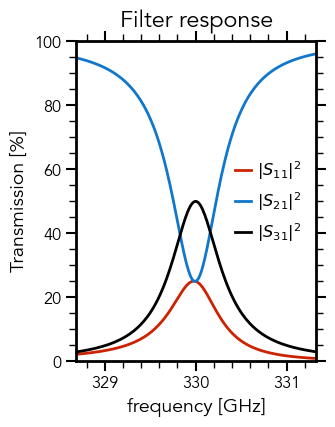

In [13]:
fig = plt.figure(figsize=(4,4))
ax = plot_centered()

f0 = single_filter_MF.f0_realized

S11_absSq = single_filter_MF.S11_absSq * 100
S21_absSq = single_filter_MF.S21_absSq * 100
S31_absSq = single_filter_MF.S31_absSq * 100

ax.plot(f/1e9,S11_absSq,label=r'$|S_{11}|^2$',color='#C20')
ax.plot(f/1e9,S21_absSq,label=r'$|S_{21}|^2$',color='#17C')
ax.plot(f/1e9,S31_absSq,label=r'$|S_{31}|^2$',color=(0.,0.,0.))

ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
ax.set_ylim(0,100)
ax.set_xlim((f0-2*f0/500)/1e9,(f0+2*f0/500)/1e9)
ax.set_title("Filter response")  # Add a title to the axes.
ax.legend(loc="right",frameon=False);  # Add a legend.
savestr = fig_path + "Response_manifold_filter.png"
fig.savefig(fname=savestr)
plt.show()

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = plot_centered()

f0 = single_filter_DF.f0_realized

S11_absSq = single_filter_DF.S11_absSq * 100
S21_absSq = single_filter_DF.S21_absSq * 100
S31_absSq = single_filter_DF.S31_absSq * 100

ax.plot(f/1e9,S11_absSq,label=r'$|S_{11}|^2$',color='#C20')
ax.plot(f/1e9,S21_absSq,label=r'$|S_{21}|^2$',color='#17C')
ax.plot(f/1e9,S31_absSq,label=r'$|S_{31}|^2$',color=(0.,0.,0.))

ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
ax.set_ylim(0,100)
ax.set_xlim((f0-2*f0/500)/1e9,(f0+2*f0/500)/1e9)
ax.set_title("Filter response")  # Add a title to the axes.
ax.legend(loc="right",frameon=False);  # Add a legend.
savestr = fig_path + "Response_manifold_filter.png"
fig.savefig(fname=savestr)
plt.show()

## Filterbank